In [1]:
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = '18-09-test/LRtrain_data.csv'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [90]:
!aws s3 cp s3://18-09-test/LR/LRtrain_data.csv ./

download: s3://18-09-test/LR/LRtrain_data.csv to ./LRtrain_data.csv


In [3]:
HasDetections = pd.read_csv('./LRtrain_data.csv')
pd.set_option('display.max_columns', 500)
HasDetections.head()

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,65,59,7800,53447.0,1.0,29.0,128035.0,18.0,35.0,-85.0,17134.0,256.0,4,272,6,137.0,13,2,2668.0,9124.0,4.0,5.0,2340.0,0,299451.0,4096.0,24,18.9,1440.0,900.0,1,52,4.294967e+09,361,10,17134.0,165.0,16,15,6,26.0,119.0,5,1,2,0.0,0.0,628.0,36144.0,0.0,0.0,0.0,0.0,10.0,0.0
1,55,26,6303,53447.0,1.0,93.0,1482.0,18.0,119.0,64.0,17134.0,256.0,4,272,6,137.0,21,8,2668.0,91656.0,4.0,5.0,2404.0,0,102385.0,4096.0,38,13.9,1366.0,768.0,3,78,1.000000e+00,357,10,17134.0,1.0,16,15,2,8.0,31.0,5,2,2,NaN,NaN,628.0,57858.0,0.0,NaN,0.0,0.0,8.0,0.0
2,65,59,7671,53447.0,1.0,86.0,153579.0,18.0,64.0,49.0,17134.0,768.0,4,272,4,137.0,13,2,4908.0,317701.0,4.0,5.0,1972.0,1,113907.0,4096.0,24,21.5,1920.0,1080.0,1,78,4.294967e+09,361,10,17134.0,165.0,2,2,6,7.0,30.0,2,1,1,NaN,NaN,142.0,52682.0,0.0,NaN,0.0,0.0,3.0,0.0
3,65,59,7722,53447.0,1.0,88.0,20710.0,NaN,117.0,115.0,17134.0,256.0,4,272,6,137.0,7,2,1443.0,275890.0,4.0,5.0,2272.0,2,227116.0,4096.0,36,18.5,1366.0,768.0,1,78,4.294967e+09,365,10,17134.0,228.0,16,15,6,17.0,64.0,2,1,1,NaN,NaN,355.0,20050.0,0.0,NaN,0.0,0.0,3.0,1.0
4,65,59,7681,53447.0,1.0,18.0,37376.0,NaN,277.0,75.0,17134.0,768.0,4,272,4,137.0,13,8,1443.0,331929.0,4.0,5.0,2500.0,0,101900.0,6144.0,41,14.0,1366.0,768.0,3,52,0.000000e+00,363,10,17134.0,191.0,2,2,7,8.0,31.0,2,1,2,0.0,0.0,355.0,19844.0,0.0,0.0,0.0,0.0,1.0,1.0


In [4]:
HasDetections.shape

(8921483, 55)

In [5]:
HasDetections.dtypes

EngineVersion                                          int64
AppVersion                                             int64
AvSigVersion                                           int64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
CountryIdentifier                                    float64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
LocaleEnglishNameIdentifier                          float64
OsBuild                                              float64
OsSuite                                              float64
OsPlatformSubRelease                                   int64
OsBuildLab                                             int64
SkuEdition                                             int64
IeVerIdentifier                                      float64
SmartScreen             

In [6]:
mid = HasDetections['HasDetections']
HasDetections.drop(labels=['HasDetections'], axis=1, inplace = True)
HasDetections.insert(0, 'HasDetections', mid)
HasDetections.head(5)

,HasDetections,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier
0,0.0,65,59,7800,53447.0,1.0,29.0,128035.0,18.0,35.0,-85.0,17134.0,256.0,4,272,6,137.0,13,2,2668.0,9124.0,4.0,5.0,2340.0,0,299451.0,4096.0,24,18.9,1440.0,900.0,1,52,4.294967e+09,361,10,17134.0,165.0,16,15,6,26.0,119.0,5,1,2,0.0,0.0,628.0,36144.0,0.0,0.0,0.0,0.0,10.0
1,0.0,55,26,6303,53447.0,1.0,93.0,1482.0,18.0,119.0,64.0,17134.0,256.0,4,272,6,137.0,21,8,2668.0,91656.0,4.0,5.0,2404.0,0,102385.0,4096.0,38,13.9,1366.0,768.0,3,78,1.000000e+00,357,10,17134.0,1.0,16,15,2,8.0,31.0,5,2,2,NaN,NaN,628.0,57858.0,0.0,NaN,0.0,0.0,8.0
2,0.0,65,59,7671,53447.0,1.0,86.0,153579.0,18.0,64.0,49.0,17134.0,768.0,4,272,4,137.0,13,2,4908.0,317701.0,4.0,5.0,1972.0,1,113907.0,4096.0,24,21.5,1920.0,1080.0,1,78,4.294967e+09,361,10,17134.0,165.0,2,2,6,7.0,30.0,2,1,1,NaN,NaN,142.0,52682.0,0.0,NaN,0.0,0.0,3.0
3,1.0,65,59,7722,53447.0,1.0,88.0,20710.0,NaN,117.0,115.0,17134.0,256.0,4,272,6,137.0,7,2,1443.0,275890.0,4.0,5.0,2272.0,2,227116.0,4096.0,36,18.5,1366.0,768.0,1,78,4.294967e+09,365,10,17134.0,228.0,16,15,6,17.0,64.0,2,1,1,NaN,NaN,355.0,20050.0,0.0,NaN,0.0,0.0,3.0
4,1.0,65,59,7681,53447.0,1.0,18.0,37376.0,NaN,277.0,75.0,17134.0,768.0,4,272,4,137.0,13,8,1443.0,331929.0,4.0,5.0,2500.0,0,101900.0,6144.0,41,14.0,1366.0,768.0,3,52,0.000000e+00,363,10,17134.0,191.0,2,2,7,8.0,31.0,2,1,2,0.0,0.0,355.0,19844.0,0.0,0.0,0.0,0.0,1.0


In [4]:
HasDetections.shape

(8921483, 55)

Next let's look at the relationship between each of the features and our target variable.

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [5]:
y = HasDetections['HasDetections']
X = HasDetections.drop(['HasDetections'], axis=1)

In [9]:
y

0          0.0
1          0.0
2          0.0
3          1.0
4          1.0
          ... 
8921478    1.0
8921479    0.0
8921480    1.0
8921481    1.0
8921482    0.0
Name: HasDetections, Length: 8921483, dtype: float64

In [10]:
X

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier
0,65,59,7800,53447.0,1.0,29.0,128035.0,18.0,35.0,-85.0,17134.0,256.0,4,272,6,137.0,13,2,2668.0,9124.0,4.0,5.0,2340.0,0,299451.0,4096.0,24,18.9,1440.0,900.0,1,52,4.294967e+09,361,10,17134.0,165.0,16,15,6,26.0,119.0,5,1,2,0.0,0.0,628.0,36144.0,0.0,0.0,0.0,0.0,10.0
1,55,26,6303,53447.0,1.0,93.0,1482.0,18.0,119.0,64.0,17134.0,256.0,4,272,6,137.0,21,8,2668.0,91656.0,4.0,5.0,2404.0,0,102385.0,4096.0,38,13.9,1366.0,768.0,3,78,1.000000e+00,357,10,17134.0,1.0,16,15,2,8.0,31.0,5,2,2,NaN,NaN,628.0,57858.0,0.0,NaN,0.0,0.0,8.0
2,65,59,7671,53447.0,1.0,86.0,153579.0,18.0,64.0,49.0,17134.0,768.0,4,272,4,137.0,13,2,4908.0,317701.0,4.0,5.0,1972.0,1,113907.0,4096.0,24,21.5,1920.0,1080.0,1,78,4.294967e+09,361,10,17134.0,165.0,2,2,6,7.0,30.0,2,1,1,NaN,NaN,142.0,52682.0,0.0,NaN,0.0,0.0,3.0
3,65,59,7722,53447.0,1.0,88.0,20710.0,NaN,117.0,115.0,17134.0,256.0,4,272,6,137.0,7,2,1443.0,275890.0,4.0,5.0,2272.0,2,227116.0,4096.0,36,18.5,1366.0,768.0,1,78,4.294967e+09,365,10,17134.0,228.0,16,15,6,17.0,64.0,2,1,1,NaN,NaN,355.0,20050.0,0.0,NaN,0.0,0.0,3.0
4,65,59,7681,53447.0,1.0,18.0,37376.0,NaN,277.0,75.0,17134.0,768.0,4,272,4,137.0,13,8,1443.0,331929.0,4.0,5.0,2500.0,0,101900.0,6144.0,41,14.0,1366.0,768.0,3,52,0.000000e+00,363,10,17134.0,191.0,2,2,7,8.0,31.0,2,1,2,0.0,0.0,355.0,19844.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921478,65,59,7727,53447.0,1.0,66.0,84963.0,NaN,89.0,88.0,16299.0,768.0,3,261,4,117.0,13,8,585.0,189419.0,4.0,1.0,142.0,0,936175.0,4096.0,38,15.5,1366.0,768.0,3,78,0.000000e+00,321,8,16299.0,431.0,2,2,6,14.0,49.0,5,1,2,NaN,NaN,556.0,63069.0,1.0,NaN,0.0,0.0,5.0
8921479,28,102,2378,59914.0,2.0,66.0,82414.0,27.0,89.0,88.0,10586.0,256.0,6,130,6,86.0,13,2,1443.0,275958.0,2.0,5.0,3366.0,3,75741.0,2048.0,44,19.0,1280.0,1024.0,5,78,4.294967e+09,99,25,10586.0,679.0,16,15,7,14.0,49.0,2,1,2,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,5.0
8921480,66,59,8057,53447.0,1.0,43.0,134580.0,27.0,53.0,42.0,16299.0,768.0,3,257,4,117.0,21,8,4904.0,315307.0,8.0,5.0,3104.0,1,242989.0,8192.0,38,15.5,1920.0,1080.0,3,78,0.000000e+00,319,6,16299.0,371.0,3,3,6,37.0,158.0,5,1,0,NaN,NaN,513.0,71061.0,1.0,NaN,0.0,0.0,7.0
8921481,62,46,7085,6630.0,3.0,207.0,159430.0,33.0,277.0,75.0,15063.0,768.0,2,252,4,108.0,21,8,2102.0,228975.0,2.0,5.0,1998.0,0,463486.0,4096.0,38,12.7,1024.0,768.0,3,78,0.000000e+00,267,5,15063.0,483.0,2,2,3,8.0,31.0,3,1,0,NaN,NaN,554.0,33142.0,1.0,NaN,0.0,0.0,13.0


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.67)

In [61]:
X_train

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier
100340,55,43,6718,53447.0,1.0,89.0,66953.0,27.0,120.0,118.0,16299.0,256.0,3,199,5,117.0,7,7,2668.0,127729.0,4.0,5.0,2284.0,476940.0,0,109899.0,4096.0,16,13.2,1366.0,768.0,3,34,0.000000e+00,212,2,16299.0,371.0,11,10,8,8.0,31.0,2,1,2,0.0,0.0,628.0,39237.0,0.0,0.0,0.0,1.0,1.0
56831,56,48,7426,47238.0,2.0,60.0,145725.0,27.0,240.0,-23.0,17134.0,768.0,4,204,3,137.0,7,7,2668.0,171184.0,4.0,5.0,2660.0,953869.0,0,907936.0,4096.0,16,27.0,1920.0,1080.0,3,29,0.000000e+00,236,5,17134.0,228.0,0,0,7,9.0,34.0,1,1,0,0.0,0.0,628.0,26441.0,1.0,0.0,0.0,0.0,15.0
242870,56,81,7238,41571.0,2.0,93.0,66987.0,18.0,277.0,75.0,10586.0,256.0,6,84,5,74.0,7,7,2206.0,241511.0,4.0,5.0,2460.0,476940.0,0,78023.0,4096.0,16,13.9,1366.0,768.0,3,42,0.000000e+00,62,12,10586.0,1176.0,11,10,7,8.0,31.0,2,1,2,0.0,0.0,500.0,33144.0,0.0,0.0,0.0,0.0,8.0
555950,56,22,7110,49951.0,2.0,51.0,13832.0,27.0,98.0,103.0,14393.0,256.0,1,145,5,98.0,7,7,530.0,276752.0,2.0,5.0,2056.0,305245.0,0,122098.0,4096.0,16,15.5,1366.0,768.0,3,34,0.000000e+00,120,0,14393.0,2007.0,11,10,7,5.0,26.0,1,1,2,0.0,0.0,142.0,53686.0,0.0,0.0,0.0,0.0,6.0
515048,52,24,6069,53447.0,1.0,149.0,62496.0,27.0,181.0,56.0,14393.0,256.0,1,184,5,94.0,3,7,2206.0,200418.0,2.0,5.0,1612.0,305245.0,0,304693.0,3072.0,16,17.1,1440.0,900.0,3,34,0.000000e+00,148,0,14393.0,576.0,11,10,8,24.0,109.0,1,1,2,0.0,0.0,500.0,33133.0,0.0,0.0,0.0,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484540,56,28,7460,41571.0,2.0,91.0,57902.0,27.0,125.0,113.0,17134.0,256.0,4,204,5,137.0,3,2,4588.0,313586.0,6.0,5.0,2748.0,114473.0,1,111032.0,16384.0,6,24.0,1920.0,1080.0,1,1,4.294967e+09,236,5,17134.0,228.0,11,10,7,15.0,58.0,1,1,3,0.0,0.0,142.0,7669.0,0.0,0.0,0.0,1.0,11.0
39722,55,48,6825,53447.0,1.0,43.0,166260.0,27.0,53.0,42.0,17134.0,256.0,4,204,5,137.0,3,7,639.0,188318.0,8.0,5.0,2940.0,114473.0,1,113458.0,16384.0,18,23.8,1920.0,1080.0,3,29,0.000000e+00,236,5,17134.0,228.0,11,10,6,8.0,158.0,1,1,2,0.0,0.0,134.0,20388.0,1.0,0.0,0.0,1.0,7.0
223938,56,24,7380,53447.0,1.0,101.0,66702.0,27.0,129.0,126.0,16299.0,256.0,3,198,5,111.0,7,3,3150.0,313506.0,4.0,5.0,2584.0,122104.0,1,116545.0,4096.0,9,12.0,2160.0,1440.0,6,34,4.130000e+02,236,5,17134.0,228.0,11,10,6,19.0,74.0,1,1,2,0.0,0.0,142.0,10760.0,1.0,0.0,1.0,0.0,9.0
322487,52,37,6156,62773.0,1.0,89.0,142110.0,27.0,277.0,75.0,16299.0,256.0,3,198,5,111.0,7,7,2102.0,242491.0,4.0,1.0,288.0,476940.0,0,44815.0,8192.0,16,13.9,1366.0,768.0,3,34,1.250000e+02,203,2,16299.0,15.0,11,10,7,8.0,31.0,2,1,2,0.0,0.0,554.0,33095.0

In [62]:
X_val

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier
34349,55,48,6695,47238.0,2.0,59.0,2674.0,27.0,77.0,74.0,16299.0,768.0,3,201,3,117.0,7,7,2102.0,238613.0,4.0,5.0,2660.0,953869.0,0,938159.0,8192.0,16,15.5,1366.0,768.0,3,34,0.000000e+00,214,3,16299.0,431.0,3,3,8,7.0,30.0,2,1,0,0.0,0.0,554.0,33133.0,1.0,0.0,0.0,0.0,11.0
10485,56,48,7141,53447.0,1.0,173.0,5433.0,18.0,224.0,16.0,16299.0,768.0,3,198,3,117.0,7,1,2206.0,245971.0,4.0,5.0,2568.0,953865.0,3,932427.0,8192.0,16,13.9,1366.0,768.0,3,34,0.000000e+00,212,2,16299.0,371.0,3,3,6,7.0,30.0,1,1,2,0.0,0.0,554.0,33111.0,1.0,0.0,1.0,0.0,11.0
306534,56,48,7193,53447.0,1.0,132.0,151175.0,27.0,277.0,75.0,17134.0,768.0,4,204,3,137.0,7,7,1443.0,256682.0,4.0,5.0,2660.0,122104.0,1,79027.0,8192.0,9,15.3,1366.0,768.0,3,34,0.000000e+00,236,5,17134.0,228.0,0,0,7,8.0,31.0,1,1,0,0.0,0.0,355.0,7116.0,0.0,0.0,0.0,0.0,3.0
307636,55,48,6825,53447.0,1.0,29.0,143155.0,18.0,35.0,-85.0,16299.0,256.0,3,199,5,117.0,7,2,4396.0,305696.0,2.0,5.0,4324.0,305245.0,3,289549.0,2048.0,6,18.4,1360.0,768.0,1,1,4.294967e+09,212,2,16299.0,371.0,11,10,7,26.0,119.0,1,0,2,0.0,0.0,520.0,2157.0,0.0,0.0,0.0,1.0,10.0
69476,56,48,7463,12202.0,2.0,97.0,129252.0,27.0,126.0,124.0,16299.0,768.0,3,198,3,135.0,7,7,585.0,189033.0,2.0,5.0,3380.0,305245.0,0,291831.0,4096.0,16,15.6,1366.0,768.0,3,34,0.000000e+00,202,2,16299.0,125.0,0,0,7,18.0,72.0,2,1,2,0.0,0.0,127.0,63269.0,0.0,0.0,0.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622760,55,43,6971,53447.0,1.0,207.0,63024.0,27.0,277.0,75.0,17134.0,256.0,4,204,5,137.0,7,3,3150.0,313506.0,4.0,5.0,2584.0,122104.0,1,115475.0,4096.0,9,12.0,2160.0,1440.0,6,34,1.380000e+02,233,5,17134.0,165.0,11,10,7,8.0,31.0,1,1,2,0.0,0.0,142.0,10759.0,1.0,0.0,1.0,0.0,13.0
276352,55,19,7076,7945.0,2.0,81.0,56441.0,18.0,107.0,-32.0,16299.0,768.0,3,198,3,117.0,3,7,525.0,331269.0,4.0,5.0,2376.0,476940.0,0,190001.0,8192.0,16,15.5,1920.0,1080.0,3,34,9.600000e+01,202,2,16299.0,125.0,0,0,8,9.0,34.0,2,1,0,0.0,0.0,142.0,70239.0,1.0,0.0,0.0,0.0,10.0
729621,55,48,6788,43927.0,2.0,88.0,20710.0,18.0,117.0,115.0,17134.0,256.0,4,204,5,137.0,7,7,2668.0,88953.0,4.0,5.0,2668.0,244198.0,1,242907.0,8192.0,16,22.0,1440.0,900.0,3,34,1.000000e+01,235,5,17134.0,191.0,11,10,6,17.0,64.0,1,1,0,0.0,0.0,628.0,57781.0,0.0,0.0,0.0,1.0,3.0
329995,55,19,7016,7945.0,2.0,141.0,165611.0,27.0,167.0,-29.0,16299.0,256.0,3,199,5,117.0,7,7,1443.0,331934.0,2.0,5.0,3280.0,305245.0,0,304693.0,4096.0,18,13.4,1280.0,800.0,3,34,0.000000e+00,212,2,16299.0,371.0,11,10,8,9.0,34.0,1,1,2,0.0,0.0,355.0,20388.0,0.0,0.0,0

In [8]:
train_new = X_train
train_new.to_csv('train_new.csv', header=False, index=False)

In [9]:
validation_data = X_val
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [10]:
import boto3
import re

# Define file names:
bucketNM = '18-09-test'
TrainFile = r'LR/Train/LRtrain_new.csv'
Valfile = r'LR/Validation/LRvalidation.csv'
ModelFolder = r'LR/model/'

# Mention file location:
s3ModelOutput= r's3://{0}/{1}'.format(bucketNM,ModelFolder)
s3Train = r's3://{0}/{1}'.format(bucketNM,TrainFile)
s3Val = r's3://{0}/{1}'.format(bucketNM,Valfile)

In [11]:
with open('train_new.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucketNM).Object(TrainFile).upload_fileobj(f)

In [12]:
with open('validation.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucketNM).Object(Valfile).upload_fileobj(f)

In [13]:
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_new.csv')).upload_file('train_new.csv')
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [14]:
import sagemaker

In [15]:
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, '1')
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1'

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

In [16]:
s3_input_train = TrainingInput(s3_data='s3://{}/{}/'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [72]:
#pip install xgboost

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time


import xgboost as xgb

start_time = time.time()

# special thanks to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# these parameters have been found via xgboost tuning, you can see my tries in the commented tuning python snippets below:
# unfortunately it takes so much time to tune and to produce the final optimal classifier due to 9h time limit in Kaggle kernels.
clf_xgb = xgb.XGBClassifier(learning_rate=0.03, 
                            n_estimators=3000, 
                            max_depth=11,
                            min_child_weight=9,
                            gamma=0.2,
                            subsample=1,
                            colsample_bytree=0.4,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            reg_alpha = 0.6,
                            reg_lambda = 3,
                            seed=42)
                            

clf_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=100, eval_metric='auc', verbose=100)

predictions = clf_xgb.predict(X_val)

print()
print(classification_report(y_val, predictions))

print()
print("accuracy_score", accuracy_score(y_val, predictions))

print()
predictions_probas = clf_xgb.predict_proba(X_val)
print("roc-auc score for the class 1, from target 'HasDetections' ", roc_auc_score(y_val, predictions_probas[:,1]))

print()
print("elapsed time in seconds: ", time.time() - start_time)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70540	validation_1-auc:0.69118
[100]	validation_0-auc:0.75733	validation_1-auc:0.71907
[200]	validation_0-auc:0.77849	validation_1-auc:0.72438
[300]	validation_0-auc:0.79216	validation_1-auc:0.72660
[400]	validation_0-auc:0.80304	validation_1-auc:0.72761
[500]	validation_0-auc:0.81073	validation_1-auc:0.72810
[600]	validation_0-auc:0.81674	validation_1-auc:0.72842
[700]	validation_0-auc:0.82281	validation_1-auc:0.72859
[800]	validation_0-auc:0.82956	validation_1-auc:0.72863
[900]	validation_0-auc:0.83522	validation_1-auc:0.72875
[1000]	validation_0-auc:0.84070	validation_1-auc:0.72872
[1024]	validation_0-auc:0.84190	validation_1-auc:0.72869

              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69    128826
         1.0       0.67      0.60      0.63    120110

    accuracy                           0.67    248936
   macro avg       0.67      0.66      0.66    248936
weighted avg       0.67      0.67      0.66    248936



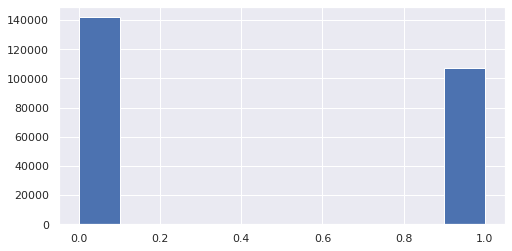

In [79]:
plt.figure(figsize=(8,4))
plt.hist(predictions)
plt.show()

In [37]:
#!pip install scikit-plot

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

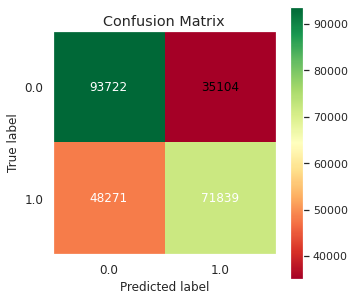

In [80]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns

sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_val, predictions, cmap="RdYlGn")

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

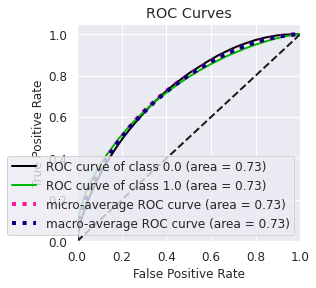

In [81]:
sns.set(rc={'figure.figsize':(4,4)})
skplt.metrics.plot_roc(y_val, predictions_probas)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

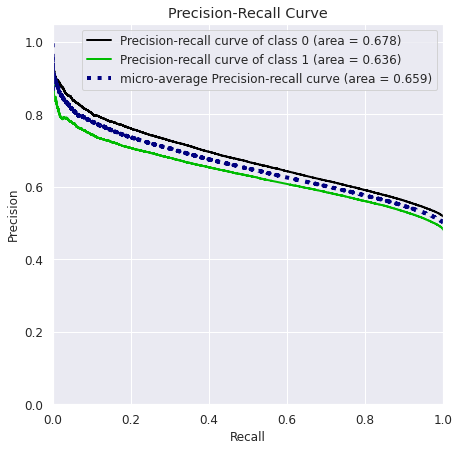

In [40]:
sns.set(rc={'figure.figsize':(7,7)})
skplt.metrics.plot_precision_recall(y_val, predictions_probas)

In [82]:
### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

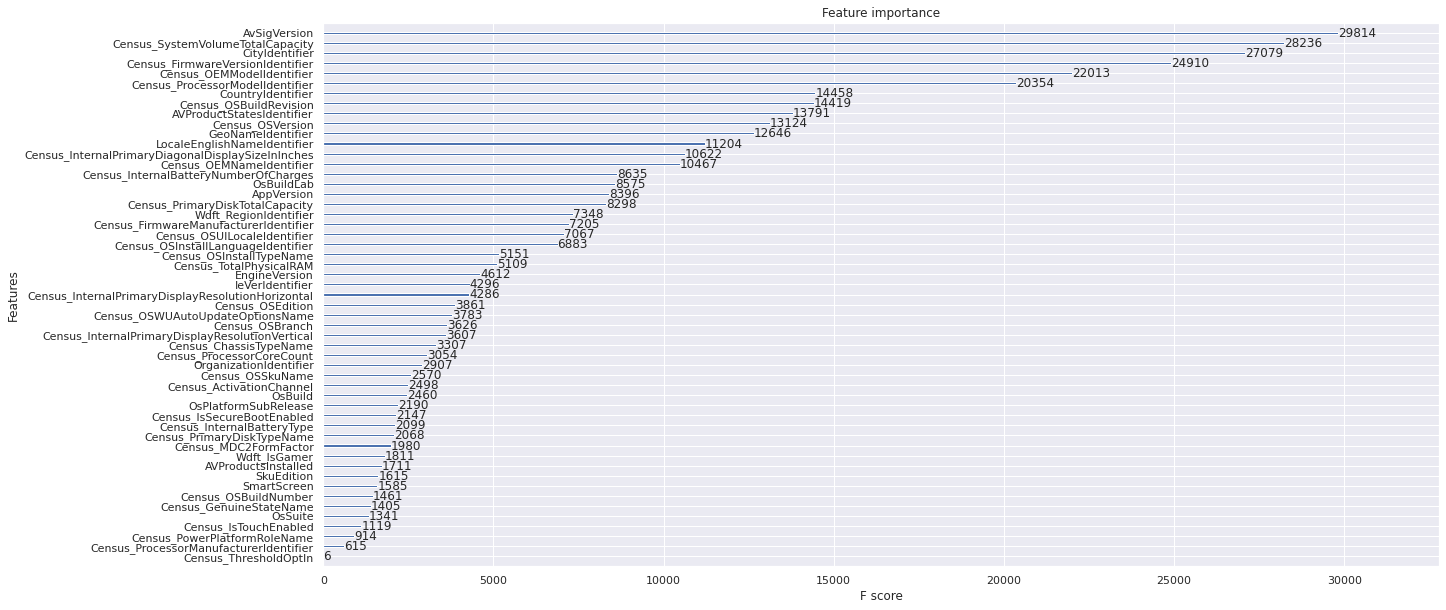

In [84]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (20, 10)
plot_importance(clf_xgb, )

In [85]:
### Pandas Profiling for Top 15 features

In [44]:
conda install pandas-profiling

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::imageio==2.9.0=py_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-spyder==0.3.2=pyhd8ed1ab_0
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib-base==3.3.4=py36hd391965_0
  - conda-forge/linux-64::spyder==4.2.0=py36h5fab9bb_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/linux-64::aiohttp==3.7.3=py36h8f6f2f9_2
  - conda-forge/noarch::pyopenssl==20.0.1=pyhd8ed1ab_0
  - cond

In [86]:
from pandas_profiling import ProfileReport

In [87]:
# Installation:
#!pip install pandas-profiling --user

# Report for a dataframe: 
from pandas_profiling import ProfileReport
report = ProfileReport(HasDetections, minimal=True)
report.to_file(output_file='report.html')
 
 

Summarize dataset:   0%|          | 0/64 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]